In [1]:
import os

import numpy as np
import torchmetrics

from classifieur.mymodel import MyModel
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from data.MRIDataModule_MAJ09122024 import MRIDataModule
from torchmetrics import Accuracy, F1Score
import seaborn as sns

In [6]:
model = MyModel

best_model_path = os.path.join('logs', '2024-12-30_092256_classifier', 'checkpoints', 'best_model-v2.ckpt')
best_model = MyModel.load_from_checkpoint(best_model_path)
best_model.eval()

tensor([0.7966, 1.0000, 0.6026])


MyModel(
  (model): ByobNet(
    (stem): Stem(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
      (conv4): ConvNormAct(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
    )
    (stages): Sequential(
      (0): Sequential(
        (0): BottleneckBlock(
          (shortcut): ConvNormAct(
            (conv): Co

In [7]:
db_path = '../data'
task = 'classification'
manifest = f'MRI_dataset_{task}.csv'
patient_split = f'patient_splits'

data = MRIDataModule(
        dataset_path=db_path,
        manifest_filename=manifest,
        batch_size=12,
        task=task,
        crop_size=None,
        train_val_test_shuffle=(True, False, False),
        train_val_test_split=(0.6, 0.2, 0.2),
        weighted_sample=False,
        seed=23,
        verbose=True,
        normalization='max',
        num_workers=None,
        patient_splits_file=patient_split)

data.setup(stage="test")
test_dataloader = data.test_dataloader() 

Train Distribution:
Class 0: 315 samples (32.11%)
Class 1: 252 samples (25.69%)
Class 2: 414 samples (42.20%)

Validation Distribution:
Class 0: 99 samples (31.43%)
Class 1: 81 samples (25.71%)
Class 2: 135 samples (42.86%)

Test Distribution:
Class 0: 117 samples (32.50%)
Class 1: 90 samples (25.00%)
Class 2: 153 samples (42.50%)



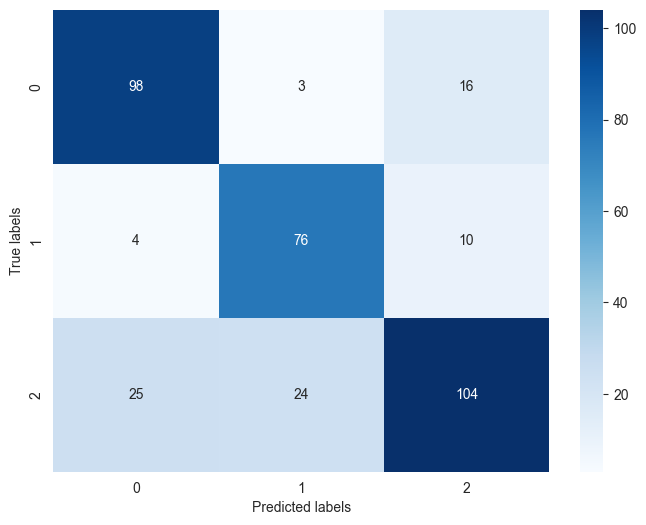

In [8]:
def get_input(batch):
        return batch['preMRI'], batch['class']

val_data = data.test_dataloader()  
 
val_labels = []
val_preds  = []
val_probs  = []  

with torch.no_grad():
    for batch in val_data:
        x, y = get_input(batch)
        x, y = x.to(best_model.device), y.to(best_model.device)
        preds = best_model(x)
        val_labels.append(y.cpu())
        val_preds.append(torch.argmax(preds, dim=1).cpu())

val_labels = torch.cat(val_labels)
val_preds  = torch.cat(val_preds)
 
cm = confusion_matrix(val_labels, val_preds, labels=[0, 1, 2])
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2])

ax.set_ylabel('True labels')
ax.set_xlabel('Predicted labels')
plt.show()

In [9]:
# Accuracy micro 

acc_micro = (104+76+98)/(98+3+16+4+76+10+25+24+104)
print(f'Accuracy micro: {acc_micro}')

Accuracy micro: 0.7722222222222223
